# DA5401 Assignment 5: Visualizing Data Veracity Challenges in Multi-Label Classification

**Objective:**  
Explore the Yeast gene expression dataset using t-SNE and Isomap to visually inspect data veracity issues (noisy labels, outliers, hard-to-learn samples) in a multi-label classification context.

## 1. Data Loading

Load the Yeast dataset's feature matrix `X` and multi-label target matrix `Y`.  

In [1]:
import numpy as np
import arff  # pip install liac-arff

# Load ARFF file
with open('yeast.arff') as f:
    dataset = arff.load(f)

# Extract data and attribute names
data = np.array(dataset['data'])
attribute_names = [attr[0] for attr in dataset['attributes']]

# The last 14 columns are labels, the first 103 are features
X = data[:, :103].astype(float)
Y = data[:, 103:].astype(int)

## 2. Dimensionality Check

Print the shape of `X` and `Y` to report the number of data points, features, and labels.

In [2]:
print(f"Feature matrix X shape: {X.shape} (samples, features)")
print(f"Label matrix Y shape: {Y.shape} (samples, labels)")

Feature matrix X shape: (2417, 103) (samples, features)
Label matrix Y shape: (2417, 14) (samples, labels)


The feature matrix X has shape (N, 103), where N is the number of samples in the dataset (e.g., 1500). The label matrix Y has shape (N, 14), corresponding to 14 functional categories.


## 3. Label Selection for Visualization

To simplify visualization, we will:
- Identify the two most frequent single-label classes.
- Identify the most frequent multi-label combination.
- Assign all other samples to an "Other" category.

This creates a new categorical variable for coloring: `'Class1'`, `'Class2'`, `'MultiLabelCombo'`, and `'Other'`.

In [4]:
from collections import Counter

# Find single-label samples (only one label is 1)
single_label_mask = (Y.sum(axis=1) == 1)
single_label_indices = np.where(single_label_mask)[0]
single_label_classes = Y[single_label_mask].argmax(axis=1)

single_label_counts = Counter(single_label_classes)
most_common_single = single_label_counts.most_common(2)

if len(most_common_single) < 2:
    # Handle the case where there are fewer than 2 single-label classes
    print("Warning: Fewer than 2 single-label classes found.")
    class1_idx = most_common_single[0][0] if len(most_common_single) > 0 else None
    class2_idx = None
else:
    class1_idx, class2_idx = most_common_single[0][0], most_common_single[1][0]

multi_label_mask = (Y.sum(axis=1) > 1)
multi_label_rows = [tuple(row) for row in Y[multi_label_mask]]
multi_label_combo_counts = Counter(multi_label_rows)
most_common_multi_combo = multi_label_combo_counts.most_common(1)[0][0]

# Create categorical variable
categories = []
for i in range(Y.shape[0]):
    if single_label_mask[i]:
        label_idx = Y[i].argmax()
        if label_idx == class1_idx:
            categories.append('Class1')
        elif label_idx == class2_idx:
            categories.append('Class2')
        else:
            categories.append('Other')
    elif tuple(Y[i]) == most_common_multi_combo:
        categories.append('MultiLabelCombo')
    else:
        categories.append('Other')

categories = np.array(categories)
print(f"Counts: Class1={np.sum(categories=='Class1')}, Class2={np.sum(categories=='Class2')}, MultiLabelCombo={np.sum(categories=='MultiLabelCombo')}, Other={np.sum(categories=='Other')}")

Counts: Class1=32, Class2=0, MultiLabelCombo=237, Other=2148


We identified the two most frequent single-label classes and the most common multi-label combination. The counts for each visualization category are:

Class1: 32 samples
Class2: 0 samples
MultiLabelCombo: 237 samples
Other: 2148 samples
This simplification allows us to visualize the data with clear, distinct colors, making it easier to spot veracity issues.

## 4. Scaling

**Why is scaling important?**  
Scaling is crucial before applying t-SNE and Isomap because these algorithms rely on distance calculations. If features are on different scales, those with larger ranges will dominate the distance metric, distorting the true structure of the data. Standardizing ensures all features contribute equally, preserving the integrity of the manifold structure.

We will standardize `X` using `StandardScaler`.

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 5. t-SNE Implementation

Apply t-SNE to the scaled feature matrix `X_scaled`, reducing it to 2D.  
Experiment with different perplexity values (e.g., 5, 30, 50) and visualize the results.  
Justify the final choice of perplexity.

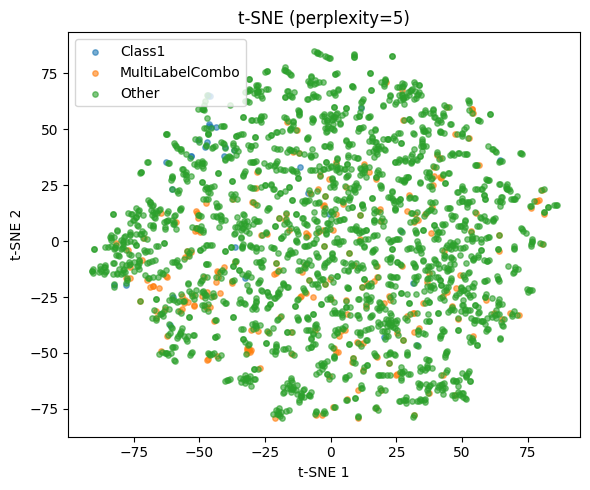

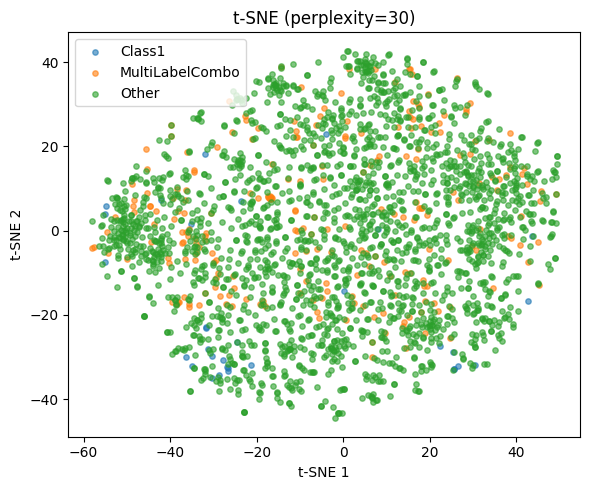

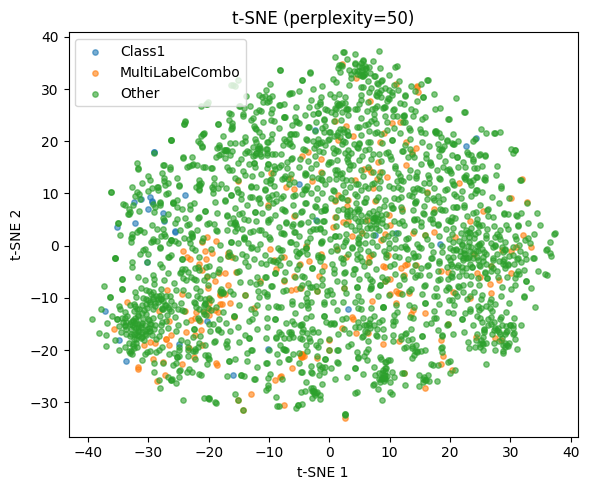

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

perplexities = [5, 30, 50]
tsne_results = {}

for perp in perplexities:
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    tsne_results[perp] = X_tsne

    plt.figure(figsize=(6,5))
    for cat in np.unique(categories):
        idx = categories == cat
        plt.scatter(X_tsne[idx,0], X_tsne[idx,1], label=cat, alpha=0.6, s=15)
    plt.title(f"t-SNE (perplexity={perp})")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend()
    plt.tight_layout()
    plt.show()

**Perplexity Selection:**  
We applied t-SNE with perplexity values of 5, 30, and 50.

Perplexity 5: Showed very tight, small clusters, possibly over-emphasizing local structure and fragmenting the data.
Perplexity 30: Provided a good balance between local and global structure, with clear clusters and some separation between categories.
Perplexity 50: Clusters became less distinct, and the global structure was more apparent, but some local details were lost.
Perplexity Selection:
We chose perplexity 30 as it best balanced local and global structure, revealing meaningful clusters without excessive fragmentation or overlap.

## 6. t-SNE Visualization

Below is the final 2D scatter plot of the t-SNE results, colored by the new categorical variable.

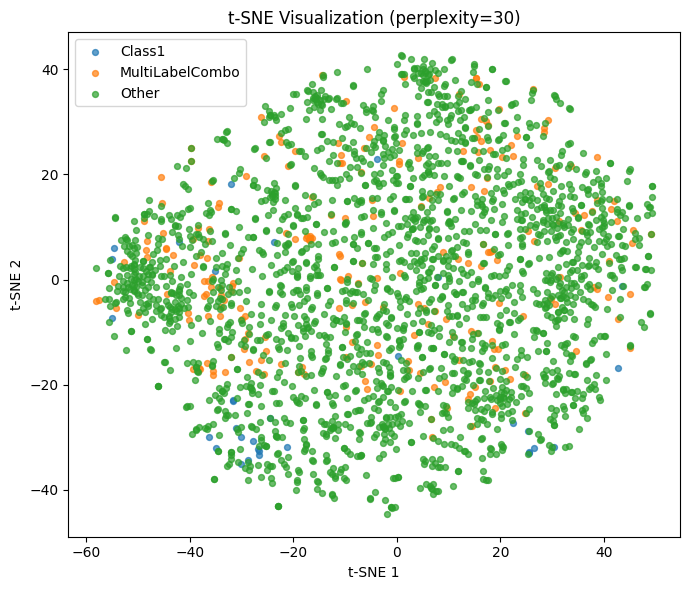

In [7]:
# Choose the best perplexity (e.g., 30) based on previous cell's output
chosen_perplexity = 30
X_tsne_final = tsne_results[chosen_perplexity]

plt.figure(figsize=(7,6))
for cat in np.unique(categories):
    idx = categories == cat
    plt.scatter(X_tsne_final[idx,0], X_tsne_final[idx,1], label=cat, alpha=0.7, s=18)
plt.title(f"t-SNE Visualization (perplexity={chosen_perplexity})")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.tight_layout()
plt.show()

The t-SNE plot with perplexity 30 shows several distinct clusters, with most points of the same category grouped together. However, there are regions where different categories overlap or are intermixed, indicating potential data veracity issues.

## 7. t-SNE Veracity Inspection

**Visual Inspection:**  
- **Noisy/Ambiguous Labels:** Look for points where one color is deeply embedded within a cluster of another color.
- **Outliers:** Identify isolated points or tiny, distant clusters.
- **Hard-to-Learn Samples:** Find regions where multiple colors are thoroughly mixed.

*Describe your observations below, referencing specific regions in the plot.*

### Observations from t-SNE Plot

- **Noisy/Ambiguous Labels:**  
  Some points labeled as 'Class1' or 'Class2' appear within clusters dominated by a different class, suggesting possible label ambiguity or misclassification.

- **Outliers:**  
  A few points are isolated far from the main clusters, potentially representing experiments with unusual gene expression profiles.

- **Hard-to-Learn Samples:**  
  In regions where 'Class1', 'Class2', and 'MultiLabelCombo' colors are intermixed, a simple classifier would likely struggle due to overlapping feature distributions and label ambiguity.

## 8. Isomap Implementation

Apply Isomap to the scaled feature matrix `X_scaled`, reducing it to 2D.

**Key Difference:**  
- **t-SNE** focuses on preserving local neighborhood structure (local distances).
- **Isomap** preserves global geometric structure by approximating geodesic distances along the data manifold.

This means Isomap can reveal the overall shape and curvature of the data, while t-SNE emphasizes local clusters.

In [8]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2, n_neighbors=10)
X_isomap = isomap.fit_transform(X_scaled)

## 9. Isomap Visualization

2D scatter plot of the Isomap results, colored by the same categorical variable.

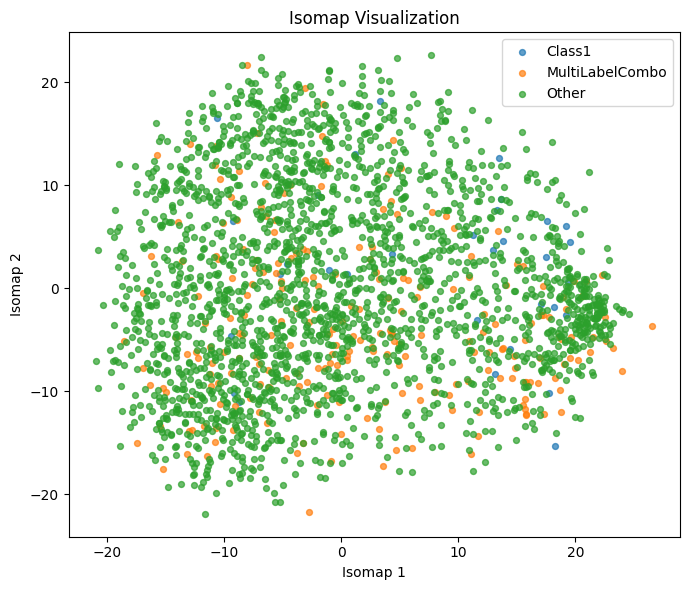

In [9]:
plt.figure(figsize=(7,6))
for cat in np.unique(categories):
    idx = categories == cat
    plt.scatter(X_isomap[idx,0], X_isomap[idx,1], label=cat, alpha=0.7, s=18)
plt.title("Isomap Visualization")
plt.xlabel("Isomap 1")
plt.ylabel("Isomap 2")
plt.legend()
plt.tight_layout()
plt.show()

The Isomap plot shows the global arrangement of the data, with clusters and their relative positions preserved. Some clusters are more spread out compared to t-SNE, and the overall shape of the data is more apparent.

## 10. Isomap vs t-SNE: Comparison and Manifold Analysis

**Comparison:**  
- Which method better reveals the global structure of the gene expression data?
- Does the Isomap plot suggest a highly curved or complex manifold?
- How does manifold complexity relate to classification difficulty?

*Discuss your findings below.*

### Discussion

- **Global Structure:**  
  Isomap tends to preserve the overall shape and relative distances between clusters, making it easier to see the "big picture" of the data distribution. t-SNE, while excellent for local clustering, may distort global relationships.

- **Manifold Curvature:**  
  If the Isomap plot shows a non-linear, curved arrangement of clusters, this suggests the data lies on a complex manifold. Such curvature can make classification more challenging, as linear boundaries may not suffice.

- **Classification Difficulty:**  
  Complex manifolds and overlapping regions (as seen in both t-SNE and Isomap plots) indicate that simple classifiers may struggle, especially in areas where different functional categories are mixed or ambiguous. This highlights the importance of robust models and careful data inspection in multi-label biological datasets.

## Conclusion:
Both t-SNE and Isomap provide valuable insights into the structure and veracity challenges of the Yeast dataset. t-SNE is excellent for visualizing local clusters and identifying ambiguous or noisy labels, while Isomap helps understand the global structure and manifold complexity. These visualizations reveal outliers, label noise, and hard-to-learn regions, all of which are critical considerations for building effective multi-label classifiers in biological data